# Et nettverk som bestemmer om Severin klatrer
Et feed forward neural network trent på Severins klatrehistorikk fra mars 2020 til juli 2020.

In [3]:
# Imports 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

from funcs import cf_matrix, plot_training, covariance

In [4]:
%load_ext autoreload
%autoreload 2

## Data håndtering
Vi bruker Pandas til å håndtere datasettet. 

In [5]:
df = pd.read_csv("climbing_data.csv")[:82]
pd.options.display.float_format = '{:,.0f}'.format

In [6]:
display(df)

,Dato,Dag,Temperatur,Klatrepartner?,Lofoten,Oslo,Sandefjord,Eftang,Tromsø,Skole eller jobb?,Klatret han?
0,28/07/2020,82,20,1,1,0,0,0,0,1,0
1,27/07/2020,81,19,1,1,0,0,0,0,0,1
2,26/07/2020,80,15,1,1,0,0,0,0,0,1
3,25/07/2020,79,13,1,1,0,0,0,0,0,1
4,24/07/2020,78,12,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
77,12/05/2020,5,5,1,0,1,0,0,0,0,1
78,11/05/2020,4,6,1,0,1,0,0,0,0,1
79,10/05/2020,3,5,0,0,1,0,0,0,0,0
80,09/05/2020,2,10,1,0,1,0,0,0,0,1


Vi fjerner "Dato" og "Dag" fra datasettet. Dato kan ikke håndteres siden det er en tekst streng. "Dag" er en nærmest vilkårlig nummerering av datoene bare basert på når datasettet startet.

In [7]:
df.drop(["Dato", "Dag"], axis=1, inplace=True)
df.head()

,Temperatur,Klatrepartner?,Lofoten,Oslo,Sandefjord,Eftang,Tromsø,Skole eller jobb?,Klatret han?
0,20,1,1,0,0,0,0,1,0
1,19,1,1,0,0,0,0,0,1
2,15,1,1,0,0,0,0,0,1
3,13,1,1,0,0,0,0,0,1
4,12,1,1,0,0,0,0,0,1


Deretter deler vi datasettet inn i input (den kaller vi X) og output (den heter y)

In [8]:
X = df.iloc[:,:-1].values.astype('int')
y = df["Klatret han?"].values.astype('int')
print("X: ")
display(X[:5])
print("Y:")
display(y[:5])

X: 


array([[20,  1,  1,  0,  0,  0,  0,  1],
       [19,  1,  1,  0,  0,  0,  0,  0],
       [15,  1,  1,  0,  0,  0,  0,  0],
       [13,  1,  1,  0,  0,  0,  0,  0],
       [12,  1,  1,  0,  0,  0,  0,  0]])

Y:


array([0, 1, 1, 1, 1])

Til slutt splitter vi til trening- og testsett.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Building the neural network
We build the model using Keras from Tensorflow.

In [12]:
model = keras.Sequential(
    [
        layers.Input((8,), name = "Input"),
        layers.Dense(4, activation="sigmoid", name="Hidden"),
        layers.Dense(1, activation='sigmoid', name="Output"),
    ],
    name="Neural_net"
)
model.compile(optimizer=Adam(), loss='binary_crossentropy')

In [10]:
train_loss = []
val_loss = []

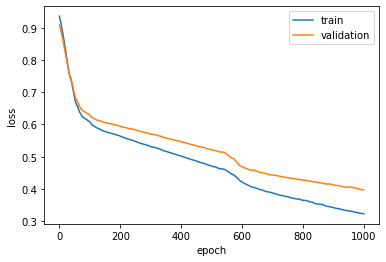

In [13]:
history = model.fit(X_train,y_train, epochs=1000, validation_data=(X_test, y_test), verbose=0)
train_loss += history.history['loss']
val_loss += history.history['val_loss']
plot_training(train_loss, val_loss)
plt.show()

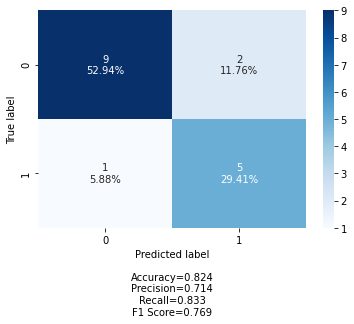

In [174]:
y_pred = model.predict(X_test).round()
cf_nn = confusion_matrix(y_test, y_pred)
cf_matrix(cf_nn)

### No:   9/11 korrekt
### Yes:  5/6 korrekt
#### Accuracy = 0.824

Below is a correlation matrix for the dataset. The way to think about correlation is that if correlation is high (close to 1) when one variable increases so does the other. If correlation is low (close to -1) then when one increases the other decreases. If it's close to zero there is little relationship about one increasing and the other decreasing.

<AxesSubplot:>

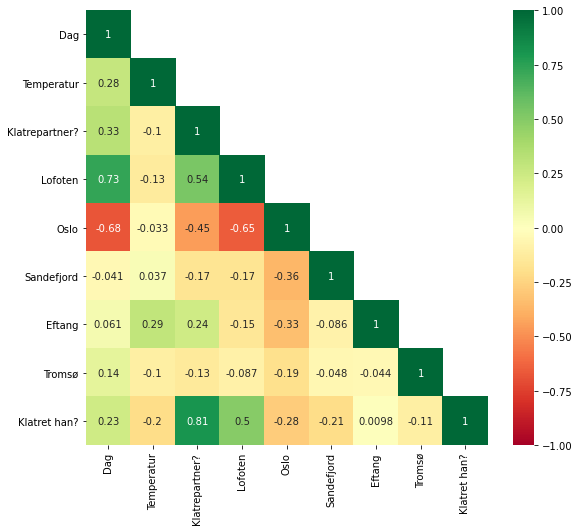

In [175]:
corr = df.iloc[:,1:].corr()
mask = np.ones_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(9,8))
sns.heatmap(corr, annot=True, cmap='RdYlGn', vmin=-1, vmax=1, mask=mask)

Code underneath gets the activation of every node in the network.

In [176]:
single = np.expand_dims(np.array([11, 1, 1, 0, 0, 0, 0, 0]).T, axis=0)

In [177]:
from tensorflow.keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

layer_outs = [func([single]) for func in functors]
layer_outs

[[array([[0.0516617, 0.140654 , 0.9485925, 0.6724979]], dtype=float32)],
 [array([[0.86321867]], dtype=float32)]]

Use in terminal to open presentation:  
jupyter nbconvert Jupyter\ climb_nn.ipynb --to slides --post serve